<a href="https://colab.research.google.com/github/ShreshthaJha6/OpenCV_Projects/blob/main/document_scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#creating a document scanner using pencv and deeplearning
#https://medium.com/@victorolufemi/build-a-document-scanner-with-opencv-ff9f645a4085
#https://www.youtube.com/watch?v=Qvn8MQ40KZk

#import packages
from skimage.filters import threshold_local #to add black and white feel to the scanned image
import cv2
import imutils #used to perform basic image processing functions
import numpy as np
from matplotlib import pyplot as plt

In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


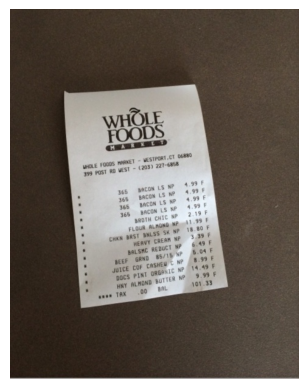

In [31]:
#to load the image
image= cv2.imread("/content/drive/MyDrive/img.jpg")
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.show()

In [32]:
original= image.copy()
#resize image
ratio= image.shape[0]/500.0
image= imutils.resize(image, height=500)

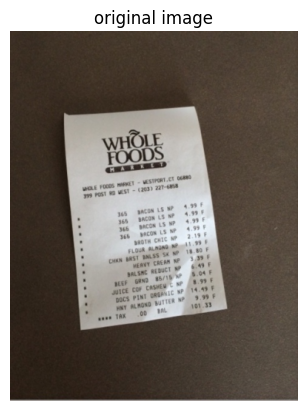

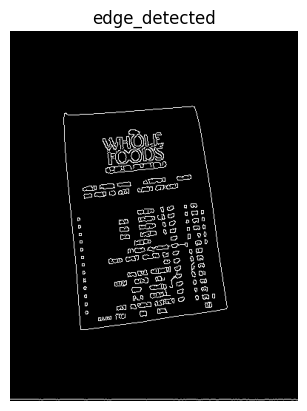

In [33]:
#GRAYCLAE- find edges in the image
gray_image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#blur the image
gray_image= cv2.GaussianBlur(gray_image,(5,5),0)

#edge detection using - Canny edge detector function
edge_image= cv2.Canny(gray_image, 75, 200)

#image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("original image")
plt.axis("off")
plt.show()

image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(edge_image, cmap="gray")
plt.title("edge_detected")
plt.axis("off")
plt.show()

In [34]:
#find contours.
#keep the largest contours.
contours_image= cv2.findContours(edge_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#grab contours- extract contours from contoours_image
contours_image= imutils.grab_contours(contours_image)

#sort contours based on size. note that- the largest contour area is the paper.
contours_image= sorted(contours_image, key=cv2.contourArea, reverse=True)[:5]

In [35]:
#processing on contours.
#loop over the contours and find the perimeter- to approximate the perimeter in points.
for contour in contours_image:
  perimeter= cv2.arcLength(contour, True)
  #approximate the contour
  approximation= cv2.approxPolyDP(contour, 0.02*perimeter, True)

  #if the contour has 4 points, then it would be the paper.
  if(len(approximation)==4):
    paper_outline= approximation
    break

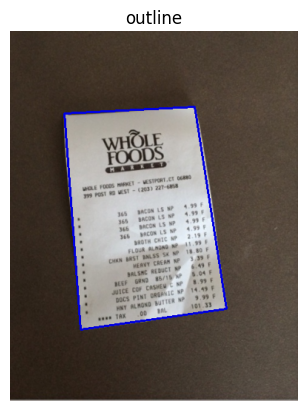

In [36]:
#draw the derived image
cv2.drawContours(image,[paper_outline],-1,(225,0,0),2)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title("outline")
plt.axis("off")
plt.show()

In [37]:
#to give 90 degree vertical view of the image from the front
#we have to tilt this image.
# arrange the points-> mark the points-> pick points from the true image

#points to note
'''SUM OF POINTS
- the largest sum of point coordinates are at the top-right corner
- the smallest sum of point coordinates are at the bottom-left corner

DIFFERENCE OF POINTS
- largest difference of point are at top-left corner
- smallest difference of point at bottom-right corner
'''
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [38]:
#set four points
def four_point_transform(image, pts):
    	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

image scan in progress


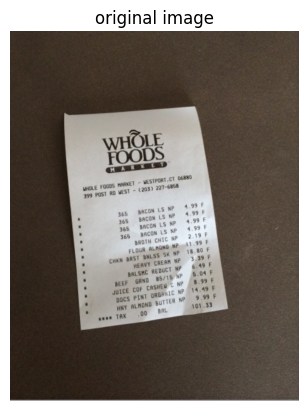

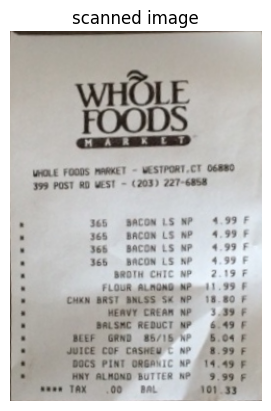

In [39]:
warped = four_point_transform(original, paper_outline.reshape(4,2)*(ratio))
#warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
#threshold = threshold_local(warped, 11, offset=10, method="gaussian")
#warped = (warped > threshold).astype("uint8") * 255

print("image scan in progress")

plt.imshow(original)
plt.title("original image")
plt.axis("off")
plt.show()

plt.imshow(warped)
plt.title("scanned image")
plt.axis("off")
plt.show()